In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing
from datetime import datetime
from datetime import date
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import pydotplus

In [339]:
# Load test and train from phase 2
test = pd.read_csv('dataset/test.csv')
train = pd.read_csv('dataset/train.csv')
dataset = pd.read_csv('dataset/train_test.csv')

In [340]:
X = dataset.drop(columns=['ssn', 'indicator'])
y = dataset.indicator

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Fáza 3 - Strojové učenie


## 1.Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu
Naimplementujte 1R algorithm (1R or OneR), ktorý je jednoduchá klasifikácia t.j. rozhodnutie na základe jedného atribútu. Môžete implementovať komplikovanejšie t.j. zahŕňajúce viacero atribútov (ich kombinácie).
Pravidlá by v tomto kroku mali byť vytvorené manuálne na základe pozorovaných závislostí v dátach. Vyhodnoťte klasifikátor pomocou metrík accuracy, precision a recall.


In [ ]:
def OneR(X_train):
    overall_best_acc = 0
    overall_best_column = None
    overall_best_predictor = None

    for column in ['leukocyty', 'trombocyty', 'alp', 'hbver', 'hemoglobin']:
        data = train[[column, 'indicator']]
        sorted_data = data.drop_duplicates([column], keep='last').sort_values(column)
        length = len(sorted_data)

        best_acc = 0
        best_column = None
        best_predictor = None
        for i in range(1, length):
            ind_one_left = 0
            ind_zero_left = 0

            ind_one_right = 0
            ind_zero_right = 0

            pom = 0
            for index, row in sorted_data.iterrows():
                if pom < i:
                    if row['indicator'] == 1.0:
                        ind_one_left += 1
                    else:
                        ind_zero_left += 1
                else:
                    if row['indicator'] == 0.0:
                        ind_zero_right += 1
                    else:
                        ind_one_right += 1
                pom += 1

            acc_one_left = ind_one_left + ind_zero_right
            acc_zero_left = ind_zero_left + ind_one_right
            acc = acc_one_left / length if acc_one_left / length >= acc_zero_left / length else acc_zero_left / length

            if best_acc < acc:
                best_acc = acc
                best_column = column
                best_predictor = train.at[i+1, column]

                if acc_one_left / length >= acc_zero_left / length:
                    predicting = 1
                else:
                    predicting = 0


        if overall_best_acc <= best_acc:
            overall_best_acc = best_acc
            overall_best_column = best_column
            overall_best_predictor = best_predictor
            overall_predicting = predicting

    return overall_best_acc, overall_best_column, overall_best_predictor, overall_predicting

overall_best_acc, overall_best_column, overall_best_predictor, overall_predicting = OneR(X_train)

print(f"Column : {overall_best_column}")
print(f"Predictor : {overall_best_predictor}")
print(f"Accuracy : {overall_best_acc}")
print(f"Predicting_left : {overall_predicting}")

In [132]:
def predict_oneR(X_test):
    predicted = []
    for index, row in X_test.iterrows():
        if row[overall_best_column] < overall_best_predictor:
            predicted.append(overall_predicting)
        elif overall_predicting == 0:
            predicted.append(1.)
        else:
            predicted.append(0.)
    predicted = np.array(predicted)
    return predicted


In [133]:
predict_oneR = predict_oneR(X_test)
oneR_summary = classification_report(y_test, predict_oneR, output_dict=True)
oneR_summary = pd.DataFrame(oneR_summary).transpose()
oneR_summary

,precision,recall,f1-score,support
0.0,0.627027,0.458498,0.529680,253.00000
1.0,0.761324,0.863636,0.809259,506.00000
accuracy,0.728590,0.728590,0.728590,0.72859
macro avg,0.694176,0.661067,0.669470,759.00000
weighted avg,0.716558,0.728590,0.716066,759.00000


## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia
Na trénovanie využite minimálne jeden stromový algoritmus strojového učenia v scikit-learn.
Vizualizujte natrénované pravidlá.
Vyhodnoťte natrénovaný model pomocou metrík accuracy, precision a recall
Porovnajte natrénovaný klasifikátor s Vašimi manuálne vytvorenými pravidlami z prvého kroku.


In [335]:
def decisionTree(clf):
    clf = clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    decisionTree_summary = classification_report(y_test, pred, output_dict=True)
    decisionTree_summary = pd.DataFrame(decisionTree_summary).transpose()
    return decisionTree_summary

clf = DecisionTreeClassifier(criterion='entropy')
decisionTree_summary = decisionTree(clf)
decisionTree_summary

,precision,recall,f1-score,support
0.0,0.796154,0.818182,0.807018,253.000000
1.0,0.907816,0.895257,0.901493,506.000000
accuracy,0.869565,0.869565,0.869565,0.869565
macro avg,0.851985,0.856719,0.854255,759.000000
weighted avg,0.870595,0.869565,0.870001,759.000000


In [336]:
pd.concat([decisionTree_summary[['precision', 'recall', 'f1-score', 'support']], oneR_summary[['precision', 'recall', 'f1-score', 'support']]], axis=1, keys=['decisionTree_summary', 'oneR_summary'])

decisionTree_summary                                  \
                        precision    recall  f1-score     support   
0.0                      0.796154  0.818182  0.807018  253.000000   
1.0                      0.907816  0.895257  0.901493  506.000000   
accuracy                 0.869565  0.869565  0.869565    0.869565   
macro avg                0.851985  0.856719  0.854255  759.000000   
weighted avg             0.870595  0.869565  0.870001  759.000000   

             oneR_summary                                 
                precision    recall  f1-score    support  
0.0              0.627027  0.458498  0.529680  253.00000  
1.0              0.761324  0.863636  0.809259  506.00000  
accuracy         0.728590  0.728590  0.728590    0.72859  
macro avg        0.694176  0.661067  0.669470  759.00000  
weighted avg     0.716558  0.728590  0.716066  759.00000

Vizualizácia

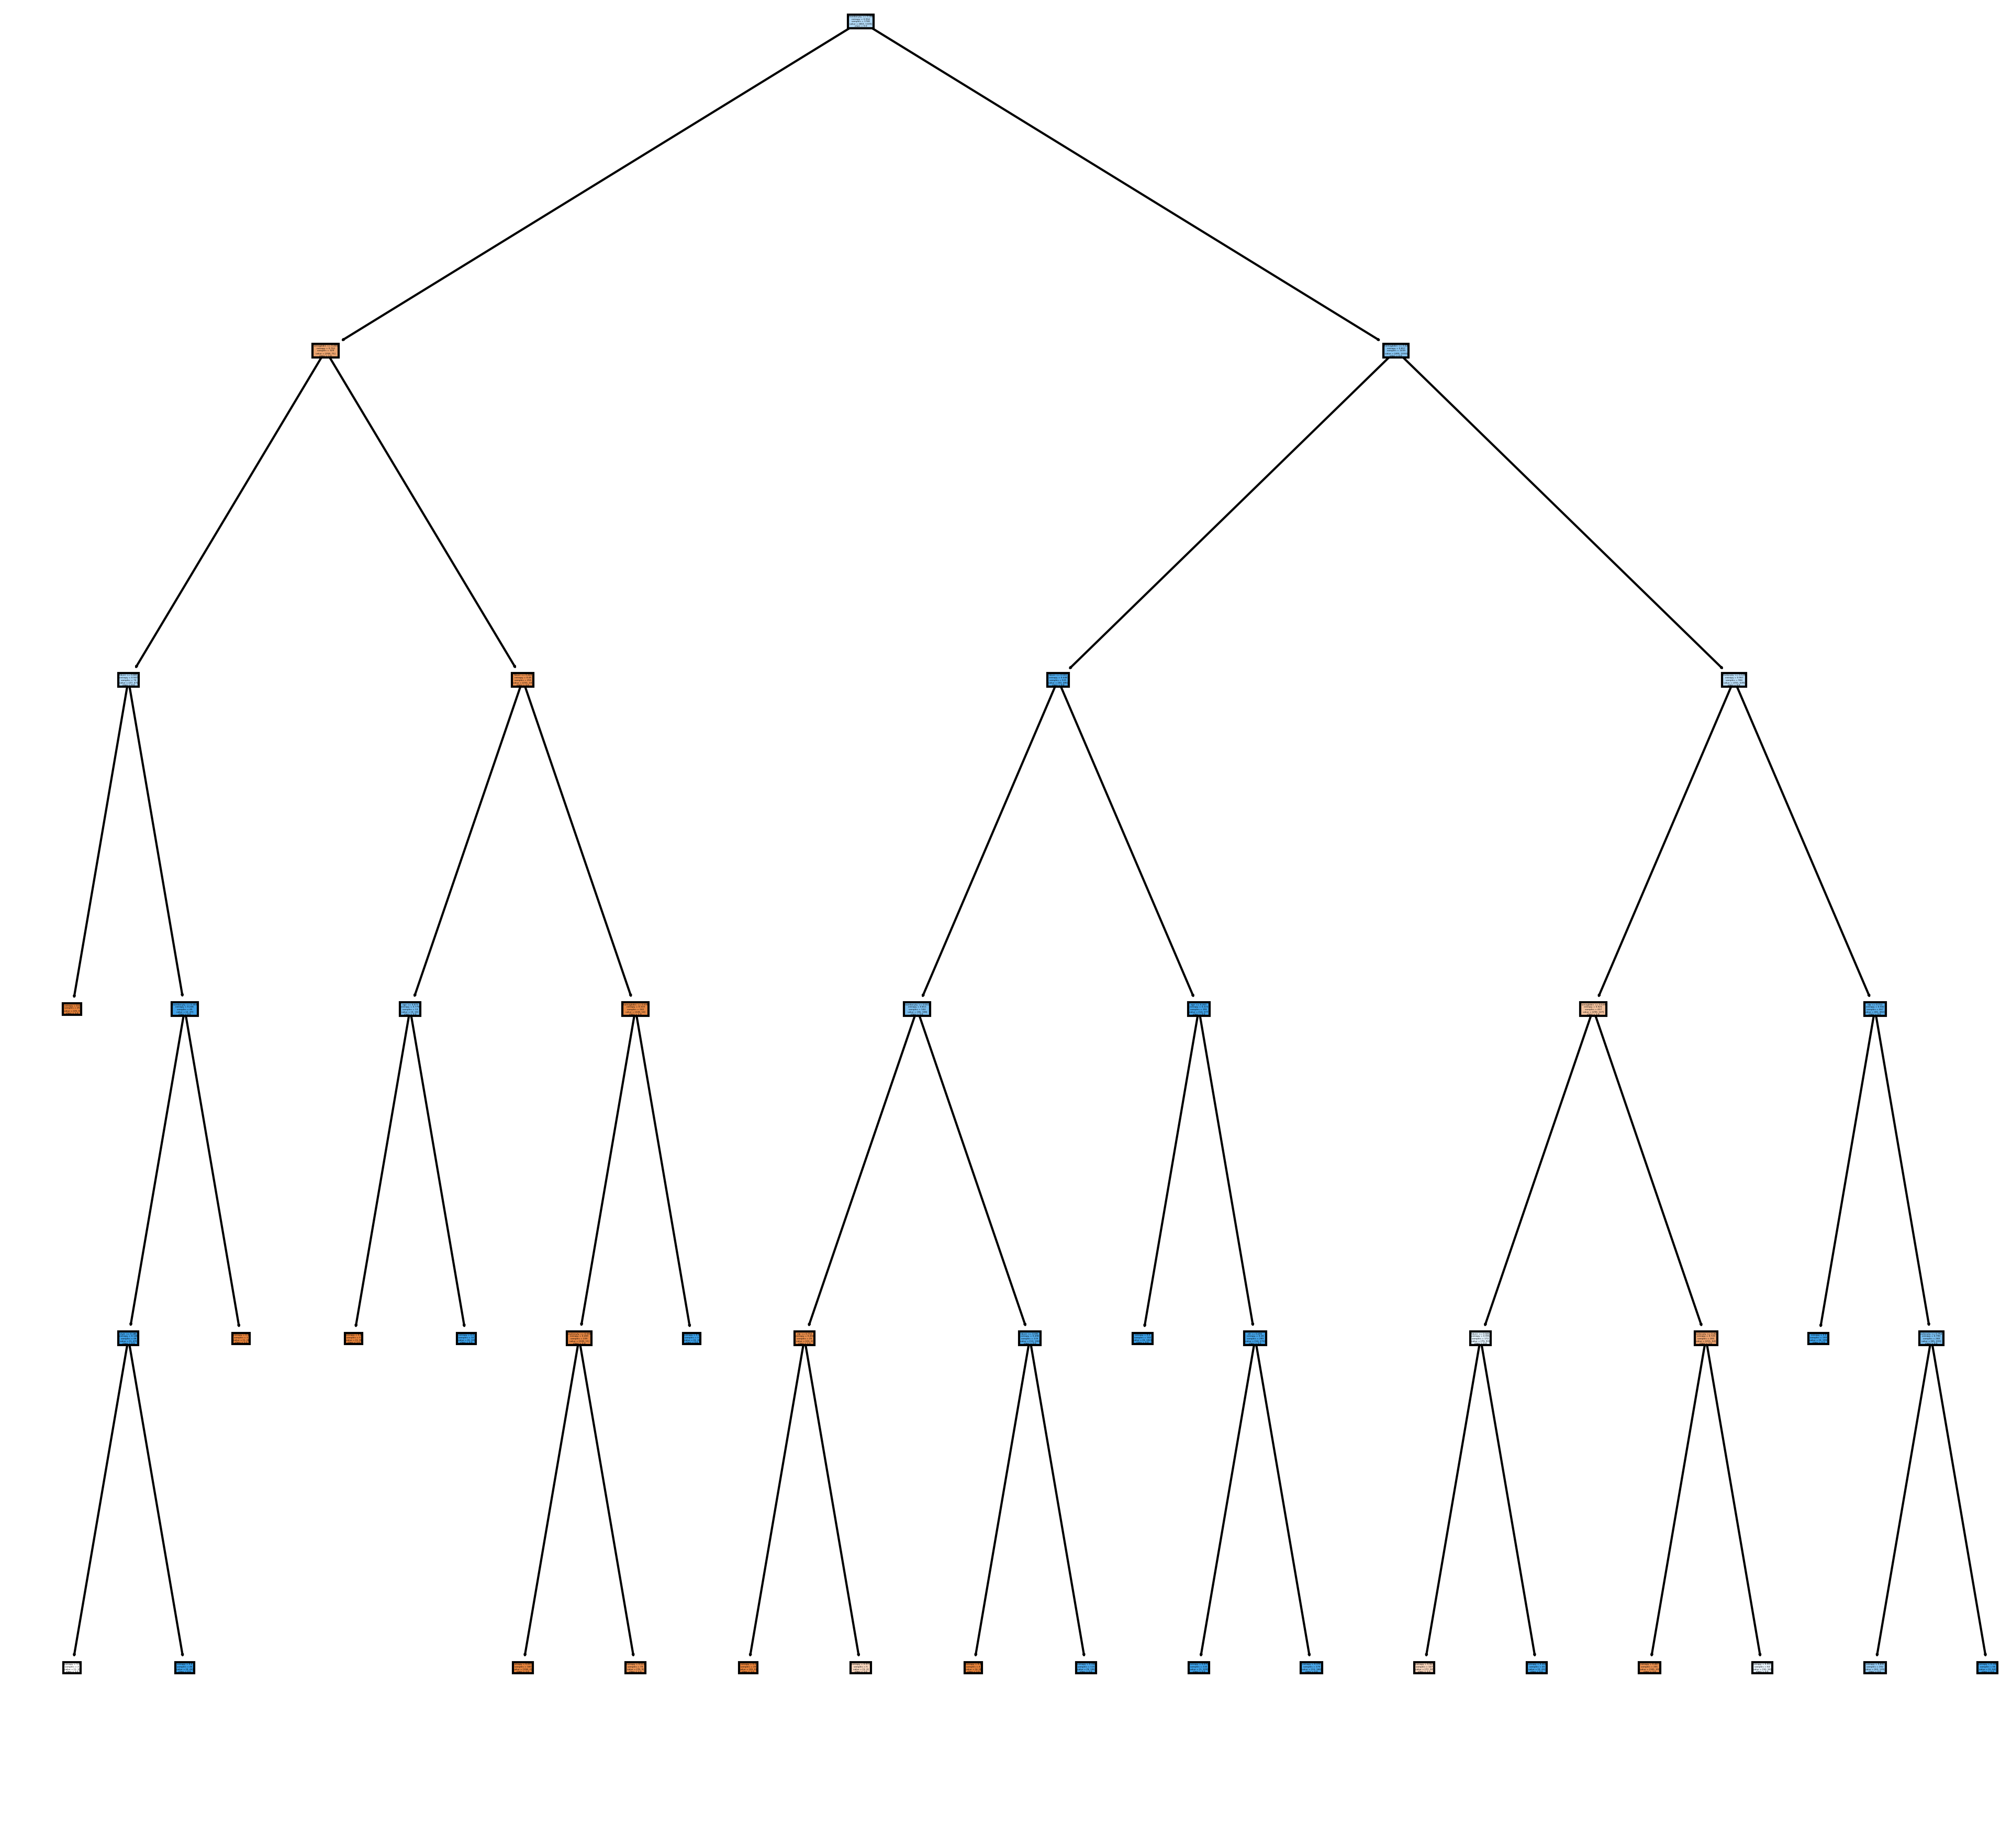

In [36]:
fig, axes = plt.subplots(figsize = (4,4), dpi=300)

plot_tree(clf,
       feature_names = X_train.columns, 
       class_names=['1.0', '0.0'],
       filled = True);

## 3. Optimalizácia - hyperparameter tuning
Preskúmajte hyperparametre Vášho zvoleného klasifikačného algoritmu v druhom kroku a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali overfitting (preučenie) a optimalizovali výsledok. 
Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite krížovú validáciu (cross validation) na trénovacej množine.

### Grid search on clf

In [16]:
clf = DecisionTreeClassifier()

parameters={
    'splitter' : ['best', 'random'],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [1, 3, 5, 7, 9, 11, 12],
    'min_samples_leaf' : [1, 2, 4, 6, 8, 10],
    'min_samples_split' : [2, 5, 10, 15, 20],
    'min_weight_fraction_leaf' : [0.1, 0.2, 0.3, 0.4],
    'max_features' : ['auto', 'log2', 'sqrt', None],
    'max_leaf_nodes' : [10, 20, 30, 40, 50]
}

clf_GS = GridSearchCV(clf, parameters)
clf_GS.fit(X_train, y_train)

print('Best Splitter:', clf_GS.best_estimator_.get_params()['splitter'])
print('Best Criterion:', clf_GS.best_estimator_.get_params()['criterion'])
print('Best Min_samples_leaf:', clf_GS.best_estimator_.get_params()['min_samples_leaf'])
print('Best Min_samples_split:', clf_GS.best_estimator_.get_params()['min_samples_split'])
print('Best Min_weight_fraction_leaf:', clf_GS.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best Max_features:', clf_GS.best_estimator_.get_params()['max_features'])
print('Best Max_leaf_nodes:', clf_GS.best_estimator_.get_params()['max_leaf_nodes'])
print(); print(clf_GS.best_estimator_.get_params())

Best Splitter: best
Best Criterion: gini
Best Min_samples_leaf: 8
Best Min_samples_split: 5
Best Min_weight_fraction_leaf: 0.1
Best Max_features: log2
Best Max_leaf_nodes: 20

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.1, 'random_state': None, 'splitter': 'best'}


In [ ]:
clf_new = DecisionTreeClassifier(criterion='gini',
                             splitter='best',
                             max_depth=12,
                             max_features='log2',
                             max_leaf_nodes=20,
                             min_samples_leaf=8,
                             min_samples_split=5,
                             min_weight_fraction_leaf=0.1,
                             random_state=None)

decisionTree_summary = decisionTree(clf_new)
decisionTree_summary

## 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu
Vyhodnotíte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy: 

Stratégie riešenia chýbajúcich hodnôt a outlierov;
Scaling resp. transformer či zlepší accuracy klasifikácie;W
Výber atribútov a výber algoritmov;
Hyperparameter tuning resp. ensemble learning.
Ktorý spôsob z každého hore-uvedených bodov sa ukázal ako vhodnejší pre daný problém? Vyhodnotenie podložíte dôkazmi.